In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np


# get MINST data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = datasets.MNIST(root='./data', train=False,
                         download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


In [2]:
# turn trainset data into tensors
train_data = torch.tensor(trainset.data)
train_data = train_data.reshape(60000, 784)
train_data = train_data.float()
train_labels = torch.tensor(trainset.targets)

# turn testset data into tensors
test_data = torch.tensor(testset.data)
test_data = test_data.reshape(10000, 784)
test_data = test_data.float()
test_labels = torch.tensor(testset.targets)

C:\Users\localnet\AppData\Local\Temp\ipykernel_76928\710913893.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(trainset.data)
C:\Users\localnet\AppData\Local\Temp\ipykernel_76928\710913893.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(trainset.targets)
C:\Users\localnet\AppData\Local\Temp\ipykernel_76928\710913893.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(testset.data)
C:\Users\localnet\AppData\Local\Temp\ipykernel_76928\710913893.py:11: Use

In [3]:
# turn labels into one-hot vectors
train_labels_one_hot = torch.zeros(60000, 10)
train_labels_one_hot.scatter_(1, train_labels.unsqueeze(1), 1)
test_labels_one_hot = torch.zeros(10000, 10)
test_labels_one_hot.scatter_(1, test_labels.unsqueeze(1), 1)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [4]:
# initialize weights: all weights are initialized to 0
w1 = torch.zeros(784, 300)
w2 = torch.zeros(300, 200)
w3 = torch.zeros(200, 100)
w4 = torch.zeros(100, 10)

# define activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# define loss function (cross-entropy)
def loss(y, y_hat):
    return torch.mean(-torch.sum(y * torch.log(y_hat), axis=1))

# define accuracy function
def accuracy(y, y_hat):
    return torch.mean((torch.argmax(y_hat, axis=1) == torch.argmax(y, axis=1)).float())

# define learning rate
lr = 0.004

# define number of epochs
epochs = 500

# train the neural network
losses = []
accuracies = []
for epoch in range(epochs):
    # forward pass
    z1 = train_data @ w1
    a1 = sigmoid(z1)
    z2 = a1 @ w2
    a2 = sigmoid(z2)
    z3 = a2 @ w3
    a3 = sigmoid(z3)
    z4 = a3 @ w4
    a4 = sigmoid(z4)

    # compute loss
    l = loss(train_labels_one_hot, a4)

    # compute accuracy
    acc = accuracy(train_labels_one_hot, a4)

    # randomly choose 64 numbers from 0 to 59999
    # and use them as indices to get 64 training examples
    indices = torch.randint(0, 60000, (64,))
    train_data_rn = train_data[indices]
    a4_rn = a4[indices]
    a3_rn = a3[indices]
    a2_rn = a2[indices]
    a1_rn = a1[indices]
    train_labels_one_hot_rn = train_labels_one_hot[indices]

    # backward pass
    dz4 = a4_rn - train_labels_one_hot_rn
    dw4 = a3_rn.t() @ dz4
    dz3 = dz4 @ w4.t() * a3_rn * (1 - a3_rn)
    dw3 = a2_rn.t() @ dz3
    dz2 = dz3 @ w3.t() * a2_rn * (1 - a2_rn)
    dw2 = a1_rn.t() @ dz2
    dz1 = dz2 @ w2.t() * a1_rn * (1 - a1_rn)
    dw1 = train_data_rn.t() @ dz1

    # update weights
    w1 -= lr * dw1
    w2 -= lr * dw2
    w3 -= lr * dw3
    w4 -= lr * dw4

    # append loss and accuracy to lists
    losses.append(l)
    accuracies.append(acc)

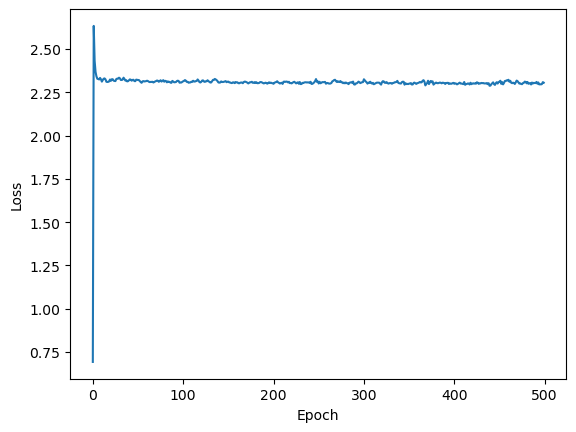

In [5]:
# plot learning curve (loss vs. epoch)
plt.plot(np.arange(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

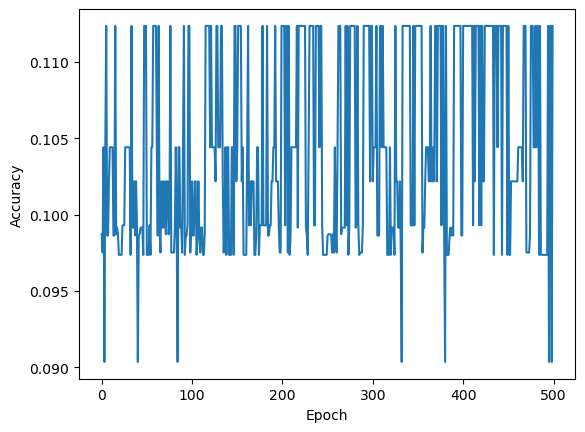

In [6]:
# plot learning curve (accuracy vs. epoch)
plt.plot(np.arange(epochs), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [7]:
# test the neural network
# forward pass
z1 = torch.matmul(test_data, w1)
a1 = sigmoid(z1)
z2 = torch.matmul(a1, w2)
a2 = sigmoid(z2)
z3 = torch.matmul(a2, w3)
a3 = sigmoid(z3)
z4 = torch.matmul(a3, w4)
a4 = sigmoid(z4)

# get predictions
_, predictions = torch.max(a4, 1)

# calculate accuracy
correct = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        correct += 1
accuracy = correct / len(predictions)
print('Accuracy: ', accuracy)

Accuracy:  0.1135


In [8]:
# initialize weights: weights are initialized to random numbers between -1 and 1
w1 = torch.rand(784, 300) * 2 - 1
w2 = torch.rand(300, 200) * 2 - 1
w3 = torch.rand(200, 100) * 2 - 1
w4 = torch.rand(100, 10) * 2 - 1

# define activation function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# define loss function (cross-entropy)
def loss(y, y_hat):
    return torch.mean(-torch.sum(y * torch.log(y_hat), axis=1))

# define accuracy function
def accuracy(y, y_hat):
    return torch.mean((torch.argmax(y_hat, axis=1) == torch.argmax(y, axis=1)).float())

# define learning rate
lr = 0.004

# define number of epochs
epochs = 500

# train the neural network
losses = []
accuracies = []
for epoch in range(epochs):
    # forward pass
    z1 = train_data @ w1
    a1 = sigmoid(z1)
    z2 = a1 @ w2
    a2 = sigmoid(z2)
    z3 = a2 @ w3
    a3 = sigmoid(z3)
    z4 = a3 @ w4
    a4 = sigmoid(z4)

    # compute loss
    l = loss(train_labels_one_hot, a4)

    # compute accuracy
    acc = accuracy(train_labels_one_hot, a4)

    # randomly choose 64 numbers from 0 to 59999
    # and use them as indices to get 64 training examples
    indices = torch.randint(0, 60000, (64,))
    train_data_rn = train_data[indices]
    a4_rn = a4[indices]
    a3_rn = a3[indices]
    a2_rn = a2[indices]
    a1_rn = a1[indices]
    train_labels_one_hot_rn = train_labels_one_hot[indices]

    # backward pass
    dz4 = a4_rn - train_labels_one_hot_rn
    dw4 = a3_rn.t() @ dz4
    dz3 = dz4 @ w4.t() * a3_rn * (1 - a3_rn)
    dw3 = a2_rn.t() @ dz3
    dz2 = dz3 @ w3.t() * a2_rn * (1 - a2_rn)
    dw2 = a1_rn.t() @ dz2
    dz1 = dz2 @ w2.t() * a1_rn * (1 - a1_rn)
    dw1 = train_data_rn.t() @ dz1

    # update weights
    w1 -= lr * dw1
    w2 -= lr * dw2
    w3 -= lr * dw3
    w4 -= lr * dw4

    # append loss and accuracy to lists
    losses.append(l)
    accuracies.append(acc)

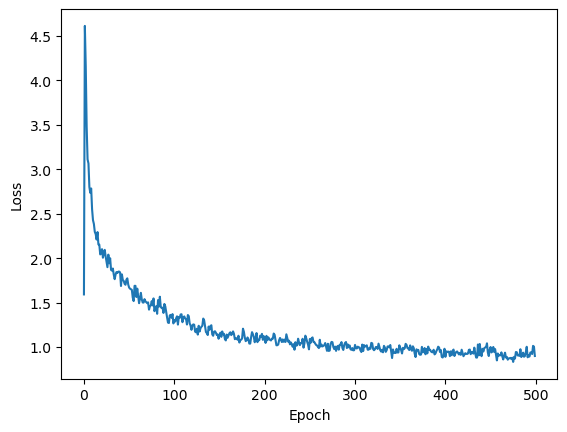

In [9]:
# plot learning curve (loss vs. epoch)
plt.plot(np.arange(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

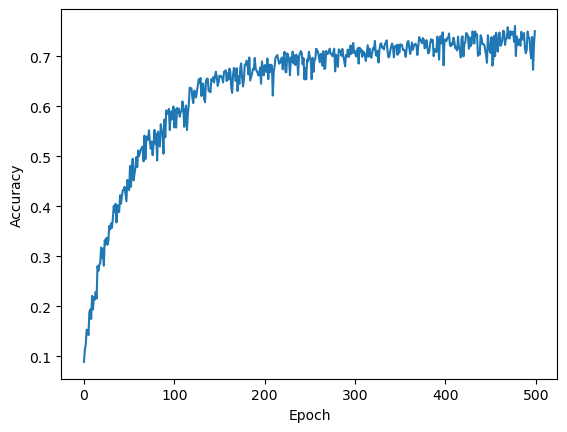

In [10]:
# plot learning curve (accuracy vs. epoch)
plt.plot(np.arange(epochs), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [11]:
# test the neural network
# forward pass
z1 = test_data @ w1
a1 = sigmoid(z1)
z2 = a1 @ w2
a2 = sigmoid(z2)
z3 = a2 @ w3
a3 = sigmoid(z3)
z4 = a3 @ w4
a4 = sigmoid(z4)

# get predictions
_, predictions = torch.max(a4, 1)

# calculate accuracy
correct = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        correct += 1
accuracy = correct / len(predictions)
print('Accuracy: ', accuracy)

Accuracy:  0.7469


In [12]:
# train a neural network using PyTorch using the same architecture
# and hyperparameters as above
# batch size = 64
# optimizer = SGD
# learning rate = 0.004
# number of epochs = 500
# activation function = sigmoid
# loss function = cross-entropy
# accuracy function = accuracy
# plot learning curve (loss vs. epoch)
# plot learning curve (accuracy vs. epoch)
# test the neural network

# define neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),
            nn.Sigmoid(),
            nn.Linear(300, 200),
            nn.Sigmoid(),
            nn.Linear(200, 100),
            nn.Sigmoid(),
            nn.Linear(100, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# initialize neural network
model = NeuralNetwork()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters())

# define number of epochs
epochs = 200

# train the neural network
losses = []
accuracies = []
for epoch in range(epochs):
    # forward pass
    logits = model(train_data)

    # compute loss
    l = loss_fn(logits, train_labels)

    # compute accuracy
    _, predictions = torch.max(logits, 1)
    correct = 0
    for i in range(len(predictions)):
        if predictions[i] == train_labels[i]:
            correct += 1
    acc = correct / len(predictions)

    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    # append loss and accuracy to lists
    losses.append(l)
    accuracies.append(acc)

    # print acc every 50 epochs
    if epoch % 50 == 0:
        print('Epoch: ', epoch, 'Accuracy: ', acc)

Epoch:  0 Accuracy:  0.09035
Epoch:  50 Accuracy:  0.8473
Epoch:  100 Accuracy:  0.8412333333333334
Epoch:  150 Accuracy:  0.84535


In [13]:
# turn l into vector
losses = torch.tensor(losses)
# turn acc into vector
accuracies = torch.tensor(accuracies)

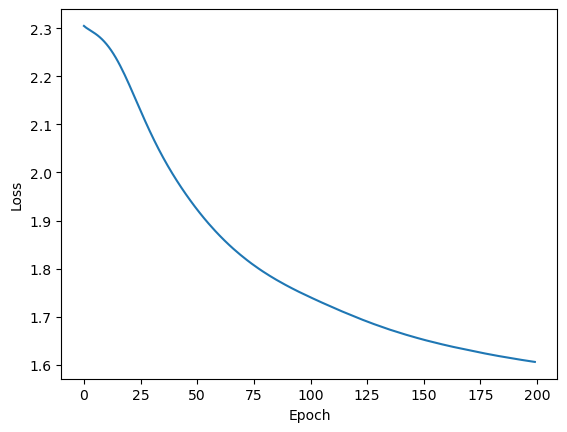

In [14]:
# plot learning curve (loss vs. epoch)
plt.plot(np.arange(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

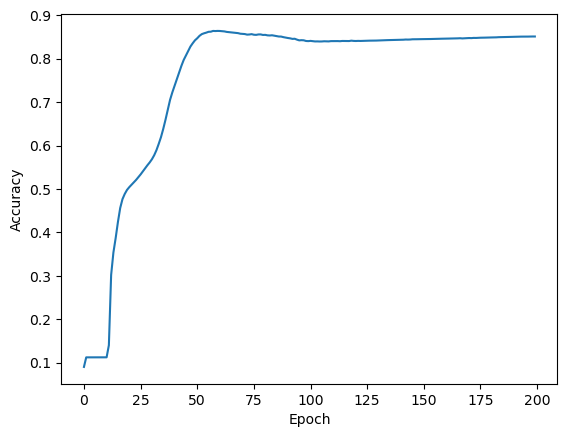

In [15]:
# plot learning curve (accuracy vs. epoch)
plt.plot(np.arange(epochs), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [16]:
# test the neural network
logits = model(test_data)
_, predictions = torch.max(logits, 1)
correct = 0
for i in range(len(predictions)):
    if predictions[i] == test_labels[i]:
        correct += 1
accuracy = correct / len(predictions)
print('Accuracy: ', accuracy)

Accuracy:  0.8291
